In [1]:
!python -V

Python 3.12.2


In [1]:
import pandas as pd

In [5]:
import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-green-taxi-trip-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716652795814, experiment_id='1', last_update_time=1716652795814, lifecycle_stage='active', name='nyc-green-taxi-trip-experiment', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.1228220948023795

/tmp/ipykernel_2626/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2626/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


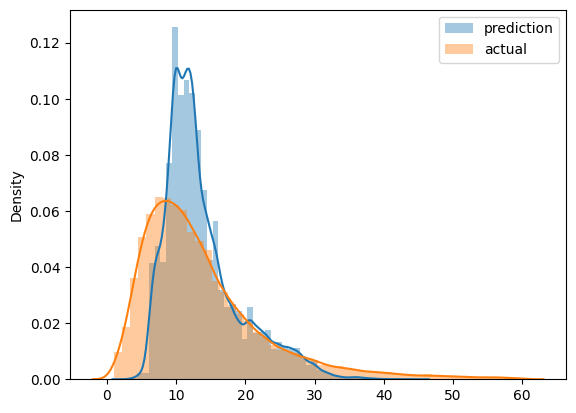

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')

In [8]:
len(df_train), len(df_val)

(54373, 51497)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.9947992164797

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.029292935675121

In [19]:
with mlflow.start_run():

    # set custom tags to filter runs
    mlflow.set_tag("Developer", "Sreekar")

    # log params that affect the model's performance
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("val-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # log metrics for comparing model's performance
    mlflow.log_metric("rmse", rmse)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [13]:
train = xgb.DMatrix(X_train, label = y_train)
val = xgb.DMatrix(X_val, label = y_val)

In [14]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(val, 'validation')],
            early_stopping_rounds = 100
        )
        y_pred = booster.predict(val)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric('rmse', rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}

In [15]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [18]:
best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

[0]	validation-rmse:8.51709                                                                 
[1]	validation-rmse:8.01331                                                                 
[2]	validation-rmse:7.58765                                                                 
[3]	validation-rmse:7.22954                                                                 
[4]	validation-rmse:6.93154                                                                 
[5]	validation-rmse:6.68491                                                                 
  0%|                                                | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:08:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:6.47866                                                                 
[7]	validation-rmse:6.30930                                                                 
[8]	validation-rmse:6.16752                                                                 
[9]	validation-rmse:6.05223                                                                 
[10]	validation-rmse:5.95838                                                                
[11]	validation-rmse:5.87922                                                                
[12]	validation-rmse:5.81408                                                                
[13]	validation-rmse:5.76120                                                                
[14]	validation-rmse:5.71988                                                                
[15]	validation-rmse:5.68434                                                                
[16]	validation-rmse:5.65466                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:09:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.63388                                                                 
[1]	validation-rmse:5.70345                                                                 
[2]	validation-rmse:5.39589                                                                 
[3]	validation-rmse:5.30123                                                                 
[4]	validation-rmse:5.26526                                                                 
[5]	validation-rmse:5.24952                                                                 
[6]	validation-rmse:5.24283                                                                 
[7]	validation-rmse:5.23744                                                                 
[8]	validation-rmse:5.23639                                                                 
[9]	validation-rmse:5.23512                                                                 
[10]	validation-rmse:5.23914                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:10:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.57973                                                                 
[1]	validation-rmse:5.34500                                                                 
[2]	validation-rmse:5.29614                                                                 
[3]	validation-rmse:5.29165                                                                 
[4]	validation-rmse:5.28212                                                                 
[5]	validation-rmse:5.27976                                                                 
[6]	validation-rmse:5.26852                                                                 
[7]	validation-rmse:5.26845                                                                 
[8]	validation-rmse:5.26011                                                                 
[9]	validation-rmse:5.25410                                                                 
[10]	validation-rmse:5.25182                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:10:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49302                                                                 
[1]	validation-rmse:7.96296                                                                 
[2]	validation-rmse:7.51148                                                                 
[3]	validation-rmse:7.12921                                                                 
[4]	validation-rmse:6.80709                                                                 
[5]	validation-rmse:6.53646                                                                 
[6]	validation-rmse:6.30933                                                                 
[7]	validation-rmse:6.11998                                                                 
[8]	validation-rmse:5.96196                                                                 
[9]	validation-rmse:5.83355                                                                 
[10]	validation-rmse:5.72839                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:11:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.23547                                                                 
[1]	validation-rmse:7.54277                                                                 
[2]	validation-rmse:7.00800                                                                 
[3]	validation-rmse:6.58405                                                                 
[4]	validation-rmse:6.27173                                                                 
[5]	validation-rmse:6.03401                                                                 
[6]	validation-rmse:5.84008                                                                 
[7]	validation-rmse:5.71073                                                                 
[8]	validation-rmse:5.61741                                                                 
[9]	validation-rmse:5.53753                                                                 
[10]	validation-rmse:5.47720                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:12:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.83299                                                                 
[1]	validation-rmse:5.39906                                                                 
[2]	validation-rmse:5.33157                                                                 
[3]	validation-rmse:5.31416                                                                 
[4]	validation-rmse:5.30154                                                                 
[5]	validation-rmse:5.29651                                                                 
[6]	validation-rmse:5.29449                                                                 
[7]	validation-rmse:5.28997                                                                 
[8]	validation-rmse:5.28660                                                                 
[9]	validation-rmse:5.26783                                                                 
[10]	validation-rmse:5.26318                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:12:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.65043                                                                 
[1]	validation-rmse:6.72879                                                                 
[2]	validation-rmse:6.16978                                                                 
[3]	validation-rmse:5.84381                                                                 
[4]	validation-rmse:5.65578                                                                 
[5]	validation-rmse:5.54798                                                                 
[6]	validation-rmse:5.48264                                                                 
[7]	validation-rmse:5.44384                                                                 
[8]	validation-rmse:5.41672                                                                 
[9]	validation-rmse:5.39873                                                                 
[10]	validation-rmse:5.38763                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:13:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.07348                                                                 
[1]	validation-rmse:7.29787                                                                 
[2]	validation-rmse:6.73039                                                                 
[3]	validation-rmse:6.32284                                                                 
[4]	validation-rmse:6.03329                                                                 
[5]	validation-rmse:5.82930                                                                 
[6]	validation-rmse:5.68721                                                                 
[7]	validation-rmse:5.58774                                                                 
[8]	validation-rmse:5.51861                                                                 
[9]	validation-rmse:5.46787                                                                 
[10]	validation-rmse:5.43380                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:14:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.54354                                                                 
[1]	validation-rmse:5.71956                                                                 
[2]	validation-rmse:5.48123                                                                 
[3]	validation-rmse:5.37574                                                                 
[4]	validation-rmse:5.34845                                                                 
[5]	validation-rmse:5.33181                                                                 
[6]	validation-rmse:5.32584                                                                 
[7]	validation-rmse:5.32473                                                                 
[8]	validation-rmse:5.32293                                                                 
[9]	validation-rmse:5.31458                                                                 
[10]	validation-rmse:5.31407                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:15:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.66458                                                                 
[1]	validation-rmse:6.74878                                                                 
[2]	validation-rmse:6.14461                                                                 
[3]	validation-rmse:5.81540                                                                 
[4]	validation-rmse:5.61923                                                                 
[5]	validation-rmse:5.50199                                                                 
[6]	validation-rmse:5.41783                                                                 
[7]	validation-rmse:5.38399                                                                 
[8]	validation-rmse:5.35918                                                                 
[9]	validation-rmse:5.33048                                                                 
[10]	validation-rmse:5.32330                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:15:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50571                                                                 
[1]	validation-rmse:7.98580                                                                 
[2]	validation-rmse:7.54911                                                                 
[3]	validation-rmse:7.17196                                                                 
[4]	validation-rmse:6.85824                                                                 
[5]	validation-rmse:6.60130                                                                 
[6]	validation-rmse:6.37354                                                                 
[7]	validation-rmse:6.19088                                                                 
[8]	validation-rmse:6.03995                                                                 
[9]	validation-rmse:5.91503                                                                 
[10]	validation-rmse:5.81123                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:16:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.27386                                                                 
[1]	validation-rmse:7.60564                                                                 
[2]	validation-rmse:7.07827                                                                 
[3]	validation-rmse:6.66822                                                                 
[4]	validation-rmse:6.35151                                                                 
[5]	validation-rmse:6.11006                                                                 
[6]	validation-rmse:5.92596                                                                 
[7]	validation-rmse:5.78606                                                                 
[8]	validation-rmse:5.68073                                                                 
[9]	validation-rmse:5.60220                                                                 
[10]	validation-rmse:5.54226                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:18:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.51691                                                                 
[1]	validation-rmse:8.00693                                                                 
[2]	validation-rmse:7.57230                                                                 
[3]	validation-rmse:7.20342                                                                 
[4]	validation-rmse:6.89241                                                                 
[5]	validation-rmse:6.63143                                                                 
[6]	validation-rmse:6.41260                                                                 
[7]	validation-rmse:6.23053                                                                 
[8]	validation-rmse:6.07997                                                                 
[9]	validation-rmse:5.95549                                                                 
[10]	validation-rmse:5.85304                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:19:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.43809                                                                 
[1]	validation-rmse:7.87323                                                                 
[2]	validation-rmse:7.40312                                                                 
[3]	validation-rmse:7.01453                                                                 
[4]	validation-rmse:6.69562                                                                 
[5]	validation-rmse:6.43548                                                                 
[6]	validation-rmse:6.22429                                                                 
[7]	validation-rmse:6.05391                                                                 
[8]	validation-rmse:5.91612                                                                 
[9]	validation-rmse:5.80566                                                                 
[10]	validation-rmse:5.71689                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:21:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.01988                                                                 
[1]	validation-rmse:7.20909                                                                 
[2]	validation-rmse:6.61933                                                                 
[3]	validation-rmse:6.19687                                                                 
[4]	validation-rmse:5.90073                                                                 
[5]	validation-rmse:5.69618                                                                 
[6]	validation-rmse:5.55670                                                                 
[7]	validation-rmse:5.46070                                                                 
[8]	validation-rmse:5.39510                                                                 
[9]	validation-rmse:5.34891                                                                 
[10]	validation-rmse:5.31935                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:21:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.20639                                                                 
[1]	validation-rmse:5.49658                                                                 
[2]	validation-rmse:5.33383                                                                 
[3]	validation-rmse:5.27511                                                                 
[4]	validation-rmse:5.26086                                                                 
[5]	validation-rmse:5.25390                                                                 
[6]	validation-rmse:5.25042                                                                 
[7]	validation-rmse:5.24794                                                                 
[8]	validation-rmse:5.24103                                                                 
[9]	validation-rmse:5.23840                                                                 
[10]	validation-rmse:5.23506                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:22:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.77600                                                                 
[1]	validation-rmse:8.46682                                                                 
[2]	validation-rmse:8.18353                                                                 
[3]	validation-rmse:7.92180                                                                 
[4]	validation-rmse:7.68426                                                                 
[5]	validation-rmse:7.46562                                                                 
[6]	validation-rmse:7.26662                                                                 
[7]	validation-rmse:7.08588                                                                 
[8]	validation-rmse:6.92318                                                                 
[9]	validation-rmse:6.77138                                                                 
[10]	validation-rmse:6.63638                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:23:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.53905                                                                 
[1]	validation-rmse:6.60402                                                                 
[2]	validation-rmse:6.07556                                                                 
[3]	validation-rmse:5.78770                                                                 
[4]	validation-rmse:5.63357                                                                 
[5]	validation-rmse:5.55164                                                                 
[6]	validation-rmse:5.50294                                                                 
[7]	validation-rmse:5.46975                                                                 
[8]	validation-rmse:5.44749                                                                 
[9]	validation-rmse:5.43511                                                                 
[10]	validation-rmse:5.42752                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:24:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.15369                                                                 
[1]	validation-rmse:7.41928                                                                 
[2]	validation-rmse:6.87170                                                                 
[3]	validation-rmse:6.47008                                                                 
[4]	validation-rmse:6.16132                                                                 
[5]	validation-rmse:5.94960                                                                 
[6]	validation-rmse:5.79030                                                                 
[7]	validation-rmse:5.67498                                                                 
[8]	validation-rmse:5.59036                                                                 
[9]	validation-rmse:5.52663                                                                 
[10]	validation-rmse:5.48448                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:25:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.92918                                                                 
[1]	validation-rmse:5.95768                                                                 
[2]	validation-rmse:5.56198                                                                 
[3]	validation-rmse:5.40929                                                                 
[4]	validation-rmse:5.34700                                                                 
[5]	validation-rmse:5.31860                                                                 
[6]	validation-rmse:5.29883                                                                 
[7]	validation-rmse:5.28841                                                                 
[8]	validation-rmse:5.28058                                                                 
[9]	validation-rmse:5.27533                                                                 
[10]	validation-rmse:5.26913                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:25:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.75541                                                                 
[1]	validation-rmse:8.42888                                                                 
[2]	validation-rmse:8.12898                                                                 
[3]	validation-rmse:7.85499                                                                 
[4]	validation-rmse:7.60409                                                                 
[5]	validation-rmse:7.37519                                                                 
[6]	validation-rmse:7.16691                                                                 
[7]	validation-rmse:6.97766                                                                 
[8]	validation-rmse:6.80576                                                                 
[9]	validation-rmse:6.65029                                                                 
[10]	validation-rmse:6.50912                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:27:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.81586
[1]	validation-rmse:8.54238                                                                 
[2]	validation-rmse:8.28948                                                                 
[3]	validation-rmse:8.05586                                                                 
[4]	validation-rmse:7.84013                                                                 
[5]	validation-rmse:7.64096                                                                 
[6]	validation-rmse:7.45864                                                                 
[7]	validation-rmse:7.29062                                                                 
[8]	validation-rmse:7.13638                                                                 
[9]	validation-rmse:6.99496                                                                 
[10]	validation-rmse:6.86500                                                                
[11]	validation-rmse:6.74633              

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:28:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67552                                                                 
[1]	validation-rmse:8.28365                                                                 
[2]	validation-rmse:7.93141                                                                 
[3]	validation-rmse:7.61807                                                                 
[4]	validation-rmse:7.33625                                                                 
[5]	validation-rmse:7.08458                                                                 
[6]	validation-rmse:6.86349                                                                 
[7]	validation-rmse:6.66461                                                                 
[8]	validation-rmse:6.48938                                                                 
[9]	validation-rmse:6.33497                                                                 
[10]	validation-rmse:6.19963                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:29:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69745                                                                 
[1]	validation-rmse:8.32332                                                                 
[2]	validation-rmse:7.98593                                                                 
[3]	validation-rmse:7.68266                                                                 
[4]	validation-rmse:7.40951                                                                 
[5]	validation-rmse:7.16333                                                                 
[6]	validation-rmse:6.94328                                                                 
[7]	validation-rmse:6.74698                                                                 
[8]	validation-rmse:6.57216                                                                 
[9]	validation-rmse:6.41432                                                                 
[10]	validation-rmse:6.27784                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:30:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68579                                                                 
[1]	validation-rmse:8.30390                                                                 
[2]	validation-rmse:7.96272                                                                 
[3]	validation-rmse:7.65626                                                                 
[4]	validation-rmse:7.38485                                                                 
[5]	validation-rmse:7.13973                                                                 
[6]	validation-rmse:6.92552                                                                 
[7]	validation-rmse:6.73443                                                                 
[8]	validation-rmse:6.56529                                                                 
[9]	validation-rmse:6.41666                                                                 
[10]	validation-rmse:6.28518                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:31:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.71437                                                                 
[1]	validation-rmse:8.35588                                                                 
[2]	validation-rmse:8.03223                                                                 
[3]	validation-rmse:7.74140                                                                 
[4]	validation-rmse:7.47911                                                                 
[5]	validation-rmse:7.24478                                                                 
[6]	validation-rmse:7.03554                                                                 
[7]	validation-rmse:6.84945                                                                 
[8]	validation-rmse:6.68197                                                                 
[9]	validation-rmse:6.53428                                                                 
[10]	validation-rmse:6.40342                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:32:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66062                                                                 
[1]	validation-rmse:8.25852                                                                 
[2]	validation-rmse:7.90037                                                                 
[3]	validation-rmse:7.58394                                                                 
[4]	validation-rmse:7.30322                                                                 
[5]	validation-rmse:7.05690                                                                 
[6]	validation-rmse:6.84075                                                                 
[7]	validation-rmse:6.64872                                                                 
[8]	validation-rmse:6.48194                                                                 
[9]	validation-rmse:6.33503                                                                 
[10]	validation-rmse:6.20551                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:33:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61274                                                                 
[1]	validation-rmse:8.17346                                                                 
[2]	validation-rmse:7.79000                                                                 
[3]	validation-rmse:7.45231                                                                 
[4]	validation-rmse:7.16027                                                                 
[5]	validation-rmse:6.90629                                                                 
[6]	validation-rmse:6.68477                                                                 
[7]	validation-rmse:6.49363                                                                 
[8]	validation-rmse:6.32964                                                                 
[9]	validation-rmse:6.18662                                                                 
[10]	validation-rmse:6.06632                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:33:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63006                                                                 
[1]	validation-rmse:8.20721                                                                 
[2]	validation-rmse:7.83717                                                                 
[3]	validation-rmse:7.51363                                                                 
[4]	validation-rmse:7.23393                                                                 
[5]	validation-rmse:6.99106                                                                 
[6]	validation-rmse:6.78162                                                                 
[7]	validation-rmse:6.60007                                                                 
[8]	validation-rmse:6.44422                                                                 
[9]	validation-rmse:6.30930                                                                 
[10]	validation-rmse:6.19504                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:34:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.39617                                                                 
[1]	validation-rmse:7.80650                                                                 
[2]	validation-rmse:7.32573                                                                 
[3]	validation-rmse:6.93553                                                                 
[4]	validation-rmse:6.62112                                                                 
[5]	validation-rmse:6.37061                                                                 
[6]	validation-rmse:6.16845                                                                 
[7]	validation-rmse:6.01511                                                                 
[8]	validation-rmse:5.88901                                                                 
[9]	validation-rmse:5.78782                                                                 
[10]	validation-rmse:5.70808                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:35:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32771                                                                 
[1]	validation-rmse:6.35953                                                                 
[2]	validation-rmse:5.85349                                                                 
[3]	validation-rmse:5.60244                                                                 
[4]	validation-rmse:5.47409                                                                 
[5]	validation-rmse:5.40544                                                                 
[6]	validation-rmse:5.36701                                                                 
[7]	validation-rmse:5.33665                                                                 
[8]	validation-rmse:5.32652                                                                 
[9]	validation-rmse:5.31695                                                                 
[10]	validation-rmse:5.31386                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:35:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60468                                                                 
[1]	validation-rmse:8.15712                                                                 
[2]	validation-rmse:7.76465                                                                 
[3]	validation-rmse:7.41976                                                                 
[4]	validation-rmse:7.12028                                                                 
[5]	validation-rmse:6.85855                                                                 
[6]	validation-rmse:6.63233                                                                 
[7]	validation-rmse:6.43592                                                                 
[8]	validation-rmse:6.26869                                                                 
[9]	validation-rmse:6.12293                                                                 
[10]	validation-rmse:5.99883                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:36:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80803                                                                 
[1]	validation-rmse:8.52596                                                                 
[2]	validation-rmse:8.26389                                                                 
[3]	validation-rmse:8.02085                                                                 
[4]	validation-rmse:7.79494                                                                 
[5]	validation-rmse:7.58638                                                                 
[6]	validation-rmse:7.39301                                                                 
[7]	validation-rmse:7.21518                                                                 
[8]	validation-rmse:7.05120                                                                 
[9]	validation-rmse:6.89960                                                                 
[10]	validation-rmse:6.76039                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:37:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80076                                                                 
[1]	validation-rmse:8.51256                                                                 
[2]	validation-rmse:8.24522                                                                 
[3]	validation-rmse:7.99778                                                                 
[4]	validation-rmse:7.76815                                                                 
[5]	validation-rmse:7.55689                                                                 
[6]	validation-rmse:7.36119                                                                 
[7]	validation-rmse:7.18164                                                                 
[8]	validation-rmse:7.01652                                                                 
[9]	validation-rmse:6.86391                                                                 
[10]	validation-rmse:6.72469                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:39:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80420                                                                 
[1]	validation-rmse:8.51866                                                                 
[2]	validation-rmse:8.25302                                                                 
[3]	validation-rmse:8.00635                                                                 
[4]	validation-rmse:7.77808                                                                 
[5]	validation-rmse:7.56635                                                                 
[6]	validation-rmse:7.37097                                                                 
[7]	validation-rmse:7.19002                                                                 
[8]	validation-rmse:7.02309                                                                 
[9]	validation-rmse:6.86945                                                                 
[10]	validation-rmse:6.72786                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:41:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.58274                                                                 
[1]	validation-rmse:8.12273                                                                 
[2]	validation-rmse:7.71942                                                                 
[3]	validation-rmse:7.37297                                                                 
[4]	validation-rmse:7.07172                                                                 
[5]	validation-rmse:6.81744                                                                 
[6]	validation-rmse:6.58590                                                                 
[7]	validation-rmse:6.40131                                                                 
[8]	validation-rmse:6.24505                                                                 
[9]	validation-rmse:6.10215                                                                 
[10]	validation-rmse:5.98320                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:42:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.84539                                                                 
[1]	validation-rmse:6.98263                                                                 
[2]	validation-rmse:6.38803                                                                 
[3]	validation-rmse:6.00288                                                                 
[4]	validation-rmse:5.76510                                                                 
[5]	validation-rmse:5.61457                                                                 
[6]	validation-rmse:5.49960                                                                 
[7]	validation-rmse:5.43933                                                                 
[8]	validation-rmse:5.40098                                                                 
[9]	validation-rmse:5.37531                                                                 
[10]	validation-rmse:5.34645                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:42:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.45729                                                                 
[2]	validation-rmse:8.17234                                                                 
[3]	validation-rmse:7.91253                                                                 
[4]	validation-rmse:7.67619                                                                 
[5]	validation-rmse:7.46069                                                                 
[6]	validation-rmse:7.26656                                                                 
[7]	validation-rmse:7.09008                                                                 
[8]	validation-rmse:6.93109                                                                 
[9]	validation-rmse:6.78693                                                                 
[10]	validation-rmse:6.65743                                                                
[11]	validation-rmse:6.54034                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:43:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.50367                                                                 
[1]	validation-rmse:5.39933                                                                 
[2]	validation-rmse:5.39469                                                                 
[3]	validation-rmse:5.39753                                                                 
[4]	validation-rmse:5.39970                                                                 
[5]	validation-rmse:5.39378                                                                 
[6]	validation-rmse:5.38258                                                                 
[7]	validation-rmse:5.37896                                                                 
[8]	validation-rmse:5.37572                                                                 
[9]	validation-rmse:5.37470                                                                 
[10]	validation-rmse:5.36807                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:43:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.33060                                                                 
[1]	validation-rmse:7.69977                                                                 
[2]	validation-rmse:7.19673                                                                 
[3]	validation-rmse:6.78700                                                                 
[4]	validation-rmse:6.46585                                                                 
[5]	validation-rmse:6.22323                                                                 
[6]	validation-rmse:6.01726                                                                 
[7]	validation-rmse:5.86538                                                                 
[8]	validation-rmse:5.74850                                                                 
[9]	validation-rmse:5.64751                                                                 
[10]	validation-rmse:5.57658                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:44:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.96400                                                                 
[1]	validation-rmse:7.12858                                                                 
[2]	validation-rmse:6.53267                                                                 
[3]	validation-rmse:6.11574                                                                 
[4]	validation-rmse:5.82697                                                                 
[5]	validation-rmse:5.62966                                                                 
[6]	validation-rmse:5.49716                                                                 
[7]	validation-rmse:5.40809                                                                 
[8]	validation-rmse:5.34714                                                                 
[9]	validation-rmse:5.30656                                                                 
[10]	validation-rmse:5.27698                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:44:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54286                                                                 
[1]	validation-rmse:8.05410                                                                 
[2]	validation-rmse:7.63666                                                                 
[3]	validation-rmse:7.28149                                                                 
[4]	validation-rmse:6.98124                                                                 
[5]	validation-rmse:6.72728                                                                 
[6]	validation-rmse:6.51510                                                                 
[7]	validation-rmse:6.33760                                                                 
[8]	validation-rmse:6.18941                                                                 
[9]	validation-rmse:6.06563                                                                 
[10]	validation-rmse:5.96436                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:45:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.17419                                                                 
[1]	validation-rmse:7.44618                                                                 
[2]	validation-rmse:6.89823                                                                 
[3]	validation-rmse:6.48376                                                                 
[4]	validation-rmse:6.15669                                                                 
[5]	validation-rmse:5.93599                                                                 
[6]	validation-rmse:5.77459                                                                 
[7]	validation-rmse:5.64492                                                                 
[8]	validation-rmse:5.55568                                                                 
[9]	validation-rmse:5.49663                                                                 
[10]	validation-rmse:5.45117                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:46:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.82099                                                                 
[1]	validation-rmse:6.94372                                                                 
[2]	validation-rmse:6.36011                                                                 
[3]	validation-rmse:5.97693                                                                 
[4]	validation-rmse:5.72425                                                                 
[5]	validation-rmse:5.58793                                                                 
[6]	validation-rmse:5.49687                                                                 
[7]	validation-rmse:5.42105                                                                 
[8]	validation-rmse:5.38665                                                                 
[9]	validation-rmse:5.36007                                                                 
[10]	validation-rmse:5.34824                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:46:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.44051                                                                 
[1]	validation-rmse:7.87645                                                                 
[2]	validation-rmse:7.40445                                                                 
[3]	validation-rmse:7.01364                                                                 
[4]	validation-rmse:6.69108                                                                 
[5]	validation-rmse:6.42628                                                                 
[6]	validation-rmse:6.21063                                                                 
[7]	validation-rmse:6.03589                                                                 
[8]	validation-rmse:5.89506                                                                 
[9]	validation-rmse:5.78130                                                                 
[10]	validation-rmse:5.68986                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:48:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.15907                                                                 
[1]	validation-rmse:6.17996                                                                 
[2]	validation-rmse:5.74926                                                                 
[3]	validation-rmse:5.53023                                                                 
[4]	validation-rmse:5.44610                                                                 
[5]	validation-rmse:5.38649                                                                 
[6]	validation-rmse:5.37442                                                                 
[7]	validation-rmse:5.36445                                                                 
[8]	validation-rmse:5.36291                                                                 
[9]	validation-rmse:5.35953                                                                 
[10]	validation-rmse:5.35661                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:48:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72894                                                                 
[1]	validation-rmse:8.38010                                                                 
[2]	validation-rmse:8.06220                                                                 
[3]	validation-rmse:7.77316                                                                 
[4]	validation-rmse:7.51090                                                                 
[5]	validation-rmse:7.27359                                                                 
[6]	validation-rmse:7.05878                                                                 
[7]	validation-rmse:6.86514                                                                 
[8]	validation-rmse:6.69136                                                                 
[9]	validation-rmse:6.53405                                                                 
[10]	validation-rmse:6.39282                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:50:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.01379                                                                 
[1]	validation-rmse:5.41498                                                                 
[2]	validation-rmse:5.29199                                                                 
[3]	validation-rmse:5.25787                                                                 
[4]	validation-rmse:5.24454                                                                 
[5]	validation-rmse:5.24403                                                                 
[6]	validation-rmse:5.23881                                                                 
[7]	validation-rmse:5.23323                                                                 
[8]	validation-rmse:5.23069                                                                 
[9]	validation-rmse:5.22924                                                                 
[10]	validation-rmse:5.22529                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:50:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.81707                                                                 
[1]	validation-rmse:8.54303                                                                 
[2]	validation-rmse:8.28746                                                                 
[3]	validation-rmse:8.05030                                                                 
[4]	validation-rmse:7.82971                                                                 
[5]	validation-rmse:7.62530                                                                 
[6]	validation-rmse:7.43588                                                                 
[7]	validation-rmse:7.26003                                                                 
[8]	validation-rmse:7.09699                                                                 
[9]	validation-rmse:6.94718                                                                 
[10]	validation-rmse:6.80795                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:52:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.24843                                                                 
[1]	validation-rmse:7.55824                                                                 
[2]	validation-rmse:7.01346                                                                 
[3]	validation-rmse:6.58474                                                                 
[4]	validation-rmse:6.25383                                                                 
[5]	validation-rmse:6.00073                                                                 
[6]	validation-rmse:5.80886                                                                 
[7]	validation-rmse:5.66304                                                                 
[8]	validation-rmse:5.55318                                                                 
[9]	validation-rmse:5.47086                                                                 
[10]	validation-rmse:5.40978                                          

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [16]:
# Disabling autolog from xgboost
mlflow.xgboost.autolog(disable = True)

In [17]:
# Running the model again with the best parameters

with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.05151930425386075,
        'max_depth': 25,
        'min_child_weight': 2.1375707556264576,
        'objective': 'reg:linear',
        'reg_alpha': 0.013424620461035791,
        'reg_lambda': 0.0025414854740249348,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=100
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:32:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.80803
[1]	validation-rmse:8.52596
[2]	validation-rmse:8.26389
[3]	validation-rmse:8.02085
[4]	validation-rmse:7.79494
[5]	validation-rmse:7.58638
[6]	validation-rmse:7.39301
[7]	validation-rmse:7.21518
[8]	validation-rmse:7.05120
[9]	validation-rmse:6.89960
[10]	validation-rmse:6.76039
[11]	validation-rmse:6.63257
[12]	validation-rmse:6.51507
[13]	validation-rmse:6.40730
[14]	validation-rmse:6.30847
[15]	validation-rmse:6.21825
[16]	validation-rmse:6.13561
[17]	validation-rmse:6.05963
[18]	validation-rmse:5.99083
[19]	validation-rmse:5.92778
[20]	validation-rmse:5.86955
[21]	validation-rmse:5.81616
[22]	validation-rmse:5.76792
[23]	validation-rmse:5.72364
[24]	validation-rmse:5.68252
[25]	validation-rmse:5.64537
[26]	validation-rmse:5.61150
[27]	validation-rmse:5.58039
[28]	validation-rmse:5.55142
[29]	validation-rmse:5.52518
[30]	validation-rmse:5.50160
[31]	validation-rmse:5.48054
[32]	validation-rmse:5.46003
[33]	validation-rmse:5.44227
[34]	validation-rmse:5.4

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:33:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [19]:
import setuptools
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():
        mlflow.log_param('train-data-path', 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
        mlflow.log_param('val-data-path', 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')
        mlflow.log_artifact('models/preprocessor.b', artifact_path = 'preprocessor')

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric('rmse', rmse)

AssertionError: /usr/local/python/3.10.13/lib/python3.10/distutils/core.py